<a href="https://colab.research.google.com/github/MiningTheSkies/Full_Waveform_Modeling_Across_Scales/blob/main/5_FEM_of_1D_steady_state_diffusion_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Preface

This notebook was put together on Google Colab and makes use of both Google Colab's specific LaTeX formatting/tags (MathJax), as well as Google Colab's 'Forms' feature. Formatting changes in GitHub are manageable but running the simulation not on Google Colab will require hardcoding the values at the approprite blocks.

#### Libraries and Functions

###### Library imports 

In [ ]:
# !pip3 install -q pypandoc

In [ ]:
# ----- Import Libraries -----
#-----------------------------
## used
import numpy as np
import matplotlib.pyplot as plt
# from scipy.integrate import odeint
# from IPython import display
plt.rcParams['figure.figsize']= [12,6]
plt.rcParams.update({'font.size': 18})

## unused
# import pandas as pd
# import itertools
# from matplotlib import gridspec

##### Functions

```
Course: GPGN 598B - Full Waveform Modelling Across Scales
Date: April 10, 2020
```
# Finite Element Method - 1D Steady State Diffusion Equation
---

## Finite Element Method
---

Write a finite-element program, using linear shape functions, to find the temperature $T$ in $[0, 1]$ such that (strong form)

$$
    \partial_x^2 T + f = 0
$$

where $f$ is a source or sink, with the following boundary conditions:

\begin{align}
    T(1) &= T_1 \\
    -\partial_x T(0) &= q_0
\end{align}

Solve this problem as follows:

1. Write the weak form of the equation by introducing the linear shape functions $N_A$ & $N_{N_{el}+1}$
2. Define the local (element level) stiffness matrix and right-hand-side vector
3. Assemble these local matrices into global matrices (global level).
4. Prescribe the number of elements ($N_{el}$). Choose a couple of cases, for example, $N_{el} = 10$ and $N_{el} = 2$.
5. Explore two sets of boundary conditions:
<ol type = "i">
    <li>$T_1 = 1$, $q_0 = 1$, and $f=0$</li>
    <li>$T_1 = 1$, $q_0 = 1$, and $f=1$</li>
</ol>

Compare the FEM solution to the exact solution to the strong form, by plotting the temperature $T$ versus $x$.

## Work
---

#### Part 1: Weak Form
Write the weak form of the equation by introducing the linear shape functions $N_A$ & $N_{N_{el}+1}$
___

Given

$$
    \partial_x^2 T + f = 0
$$
1. Add test vectors to the strong form, where $\omega(1)=0$

\begin{align}
    \omega\partial_x^2 T + \omega f &= 0
\end{align}

2. Integrate over the domain $[0, 1]$ using integration by parts

    2.1. Add integrands
\begin{equation}
    \omega\partial_x^2 T + \omega f = 0 \\
    \int_0^1\omega\partial_x^2 Tdx + \int_0^1\omega f dx = 0
\end{equation}

    2.2. Integate the first term by part
\begin{equation}
    \int_0^1\omega\partial_x^2 Tdx = \big[\omega\partial_x T\big]_0^1 - \int_0^1 \partial_x T\partial_x \omega dx
\end{equation}

    2.3. Substitute back into previous equation
\begin{equation}
    - \int_0^1\partial_x T\partial_x \omega dx + \big[\omega\partial_x T\big]_0^1 + \int_0^1\omega f dx = 0
\end{equation}

    2.4. Apply boundary conditions and simplify
\begin{equation}
    - \int_0^1\partial_x T\partial_x \omega dx + \big[\omega\partial_x T\big]_0^1 + \int_0^1\omega f dx = 0 \\
    - \int_0^1\partial_x T\partial_x \omega dx - \omega(0)\partial_x T(0) + \int_0^1\omega f dx = 0 \\
    - \int_0^1\partial_x T\partial_x \omega dx + \omega(0)q_0 + \int_0^1\omega f dx = 0
\end{equation}

3. Simplify notation

    Let $a(\omega, T) \equiv \int_0^1\partial_x \omega\partial_x T dx$

    Let $(\omega,f) \equiv \int_0^1\omega fdx$

    $\therefore \quad \omega(0)q_0 - a(\omega, T) + (\omega,f) = 0$

4. Rewrite with shape functions

    4.1. Write as shape functions where
$$
    \omega(x) = \sum_{A=1}^{Nel} C_A N_A(x) \\
    T(x) = \sum_{A=1}^{Nel}d_A N_A(x) + T_1 N_{Nel+1}(x)
$$
Where $N_A(1) = 0$ and $N_{Nel+1}(1) = 1$

    4.2. Rewrite
\begin{equation}
    - \int_0^1\partial_x \omega\partial_x T dx + \int_0^1\omega f dx + \omega(0)q_0 = 0 \\[5pt]
\end{equation}
\begin{align}
    &-\int_0^1\Big(\sum_AC_A\partial_x N_A\Big)\Big(\sum_Bd_B\partial_xN_B\Big)dx \\
        &-\int_0^1\Big(\sum_AC_A\partial_xN_A\Big)\Big(T_1\partial_xN_{Nel+1}\Big)dx \\
        &+\int_0^1\Big(\sum_AC_A\partial_xN_Af\Big)dx
        +q_0\sum_AC_AN_A(0) = 0
\end{align}

    4.3. Simplify by zeroing most coefficients ($C$) except one, which will be equal to 1, such that
\begin{equation}
    -\sum_B\int_0^1\partial_xN_Ad_B\partial_xN_Bdx
        -\int_0^1\partial_xN_AT_1\partial_x N_{Nel+1}dx
        +\int_0^1 N_A f dx + q_0N_A(0) = 0
\end{equation}

Further, we define the _Stiffness_ and _Force_ matrices as follows:

Stiffness Matrix:
\begin{equation}
    K_{AB} \equiv a\big(N_A, N_B\big) = \int_0^1\partial_xN_A\partial_xN_Bdx
\end{equation}

Force Matrix:
\begin{equation}
    F_A \equiv \int_0^1N_Afdx + q_0N_A(0) - T_1a\big(N_A, N_{Nel+1}\big)
\end{equation}

Where

\begin{align}
    K_{AB}\;d_B = F_A \\
    d_B = K_{AB}^{-1}\,F_{A}
\end{align}

In [ ]:
# Initialize parameters

Nx = 12             # number of elements (Nel)
Nel = 2             # number of shape functions
T = np.zeros(Nx)    # Temperature (solution) vector
f1 = np.zeros(Nx)   # Source vector (all = 0) - first case
f2 = np.ones(Nx)    # Source vector (all = 1) - 2nd case

x = np.linspace(0, 1, Nx+1) # x values in [0,1]
h = x[1] - x[0]             # Width of each element (uniform width)

# Bounds
RB = T1 = 1
LB_d = q0 = 1

In [ ]:
x

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])

#### Local Stiffness Matrix & RHS Vector & Local to Global

Global Level
\begin{align}
    K_{AB} &= \int_0^1\partial_xN_A\partial_xN_Bdx \\
    F_A &= \int_0^1N_Afdx + q_0N_A(0) - T_1\int_0^1\partial_xN_A\partial_xN_{Nel+1}dx
\end{align}

Elemental Level
\begin{align}
    k_{ab}^e &= \sum_{e=1}^{Nel}\int_{\Omega_e}\partial_xN_a\partial_xN_bdx \\
    f_a^e &= \int_{\Omega_e}N_afdx + q_0N_a(0) - T_1\int_{\Omega_e}\partial_xN_A\partial_xN_{Nel+1}dx
\end{align}
    Since $N_A(0)$ is only defined at the left bound and is multiplied by a constant, $q_0N_A(0)$ is equivalent to $q_0\delta_{a1}$. Likewise, since $N_{Nel+1}$ is only defined at the right bound, it becomes equivalent to $k_{ab}^e$ when $e=Nel$; therefore, at $e=Nel$, the term is equivalent to $-T_1k_{a(Nel)}^e$. This leads to:

\begin{align}
    f_a^e =\int_{\Omega_e}N_afdx + 
        \begin{cases}
            q_0\delta_{a1} \qquad&\text{if}\qquad e=1 \\
            -T_1k_{a(Nel)}^e \qquad&\text{if}\qquad e=Nel \\
            0 \qquad&\text{else}
        \end{cases}
\end{align}

Reference Domain
> Use Jacobian to transition. Reference domain is $[-1, 1]$.

\begin{align}
    k_{ab}^e &= \int_{-1}^1\partial_\xi N_a \frac{d\xi}{dx}\partial_\xi N_b \frac{d\xi}{dx} \bigg(\frac{dx}{d\xi}\bigg)d\xi \\[10pt]
    f_a^e &= \int_{-1}^1N_a\frac{d\xi}{dx}fd\xi + 
        \begin{cases}
            q_0\delta_{a1} \qquad&\text{if}\qquad e=1 \\
            -T_1k_{a2}^e \qquad&\text{if}\qquad e=Nel \\
            0 \qquad&\text{else}
        \end{cases}
\end{align}

Using
\begin{align}
    \frac{d\xi}{dx} = \frac{2}{h_e} \qquad\qquad
    \frac{dx}{d\xi} = \frac{h_e}{2}
\end{align}

We can rewrite as

\begin{align}
    k_{ab}^e &= \frac 2{h_e}\int_{-1}^1\partial_\xi N_a \partial_\xi N_b d\xi \\[10pt]
    f_a^e &= \frac {h_e}2\int_{-1}^1N_afd\xi + 
        \begin{cases}
            q_0\delta_{a1} \qquad&\text{if}\qquad e=1 \\
            -T_1k_{a2}^e \qquad&\text{if}\qquad e=Nel \\
            0 \qquad&\text{else}
        \end{cases}
\end{align}

Furthermore, we use the 3-point difference for each $\xi(x)$ to arrive at the following equations:

\begin{align}
    \xi(x) &= \frac{2x-x_A-x_{A+1}}{h_e} \\
    x(\xi) &= \frac 12\big(h_e\xi(x)+x_A+x_{A+1}\big)
\end{align}

Since we use 2 shape functions as well (in this case), we define

$$
    N_a(\xi) = \frac 12(1+\xi_a\xi)
$$
Leading to
$$
    \partial_\xi N_a = \frac {\xi_a}{2} = \frac 12(-1)^a
$$

We can finally rewrite the integrals as sums, apply $N_a$ or the derivative of $N_a$ with respect to $\xi$, and transform into matrix or vector notation. This is only possible because we have a known and fixed number of shape functions. Thus, our stiffness matrix and force vector are:

\begin{align}
    k_{ab}^e &= \sum_{a,b}^2\frac{1}{h_e}(-1)^{a+b} \\
    k^e &= \frac{1}{h_e}
        \begin{bmatrix}
             1 & -1 \\
            -1 &  1
        \end{bmatrix} \\[10pt]
    f_a^e &= \frac{h_e}{2}\sum_{a}^2N_af \\
    f^e &= \frac{h_e}{4}
        \begin{bmatrix}
            (1-\xi)f \\
            (1+\xi)f
        \end{bmatrix} +
            \begin{cases}
                q_0\delta_{a1} \qquad&\text{if}\qquad e=1 \\
                -T_1k_{a2}^e \qquad&\text{if}\qquad e=Nel \\
                0 \qquad&\text{else}
            \end{cases}
\end{align}

> NOTE: I am unclear on the class notes where $f^e$ transformed into matrix form, particularly since it's only out of a single dimension ($A$) and is even called the force _vector_. I believe the notes may have had a typo on this, or I could just be lost on how we arrived at that representation.

Text(0.5, 1.0, 'Stiffness Matrix')

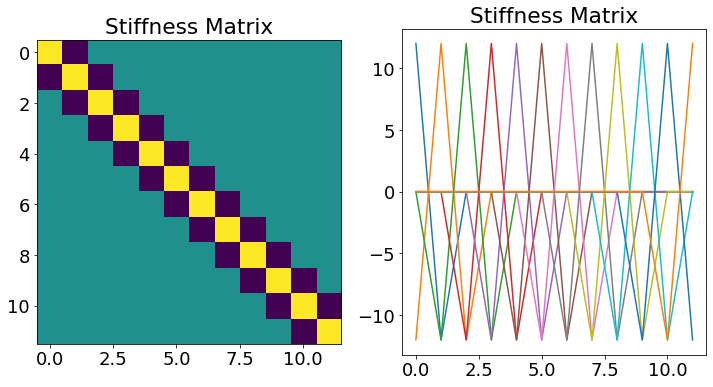

In [ ]:
# Stiffness Matrix (K_ij)

def stiffness_matrix(Nel,h):
    K = np.zeros((Nel, Nel))
    for i in range(Nel):
        for j in range(Nel):
            if i == j:
                K[i, j] = 1/h
            elif i == j + 1:
                K[i, j] = -1/h
            elif i + 1 == j:
                K[i, j] = -1/h
            else:
                K[i, j] = 0
    return K

fig, axs = plt.subplots(1,2)
axs[0].imshow(K)
axs[0].set_title("Stiffness Matrix")
axs[1].plot(K)
axs[1].set_title("Stiffness Matrix")

In [ ]:
# Force vector (RHS) - needs to be fixed

def RHS(Nel, h, f, q0, T1):
    f_vec = np.zeros(Nel)
    for i in range(Nel):
        if i == 0:
            f[i] = h/4 * 2 * f
        else:
            f[i] = h/4 * f
    
    f[0] += q0  # edit after determining what \delta is supposed to be
    f[-1] += -T1 * stiffness_matrix(Nx,h)[-1,-1]    # double check this - I think it is incorrect

    return f_vec

Map from local to global where the reference domain is defined on $|\xi_1,\xi_2|$ where $\xi_1 = -1$ and $\xi_2 = 1$ for any subset of the global domain $\big[X_A, X_{A+1}\big]$.

In [ ]:
# take to global (it's hodgepodged above - separete it out)
for i in range(Nx):         # loop through the elements
    for j in range(Nel):    # loop through the shape functions


# only thing left to do is fix the Nx and Nel confusion, finish the global/local for-loop, then run it.
# fix the RHS function to take into consideration Nx, not just Nel